# Censoring rate sensitivity analyis

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxPH, DeepHit

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

from google.colab import drive

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt

import torchtuples as tt
from pycox.models import CoxPH, DeepHit
from pycox.evaluation import EvalSurv

In [83]:
from pycox.simulations import base 
from pycox.simulations import discrete_logit_hazard , relative_risk, SimStudyLinearPH, SimStudySACCensorConst


In [84]:
#Different censoring rate
a1 = SimStudyLinearPH(c0 = 1) # 1%
a25 = SimStudyLinearPH(c0 = 25) # 25 %
a50= SimStudyLinearPH(c0 = 50) # 50%
a75= SimStudyLinearPH(c0 = 75) # 75%
a99 = SimStudyLinearPH(c0 = 99) # 99%

In [85]:
#function to create simulated 
def data_pre(var):
    # dataframe from the simulation
    data = var.dict2df(var.simulate(1000))
    train = data
    test = data.sample(frac=0.2)
    val= data.sample(frac=0.2)
    return train, test, val



In [86]:
# function to standardize X 
def stand_data(data):
    # data is dataframe to standardize
    Y= lambda data: (data['duration'].values, data['event'].values)

    # to standardize and get dependent variables 
    X= ['x0', 'x1', 'x2', 'duration_true', 'event_true',
       'censoring_true'] # list of variables for standardization

    standardize_sim = [([sim], StandardScaler()) for sim in X] #standardize function 
    

    X_map_sim = DataFrameMapper(standardize_sim)
    x = X_map_sim.fit_transform(data).astype('float32') # x simulate data
    
    y = Y(data) # y variables
    return x, y


In [87]:
# function to create neural network
def arch_net (x_data):
    # x_data x dataframe
    in_features = x_data.shape[1]
    num_nodes = [32, 32]
    out_features = 1
    batch_norm = True
    dropout = 0.1
    output_bias = False

    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                  dropout, output_bias=output_bias)
    return net


## insert %

In [202]:
df_train, df_test, df_val = data_pre(a25)

In [203]:
x_train , y_train = stand_data(df_train)
x_test = stand_data(df_test)[0] # x test 
duration_test, event_test = stand_data(df_test)[1] #y _test
val = stand_data(df_val)

In [204]:
net = arch_net(x_train)
model_cox = CoxPH(net, tt.optim.Adam) #cox model on the neural network with Adam optimizer

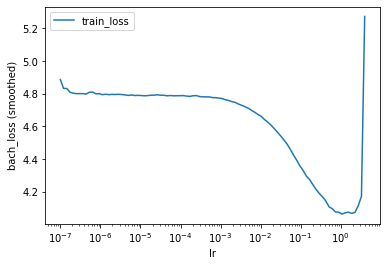

In [205]:
lrfinder_cox = model_cox.lr_finder(x_train, y_train, batch_size = 256, tolerance=10) 
_ = lrfinder_cox.plot()

In [206]:
# setting the learnig rate 
model_cox.optimizer.set_lr(0.01)

In [207]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = None
verbose = False
batch_size = 256

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data =val,  val_batch_size=batch_size)

Text(0, 0.5, 'Loss')

<Figure size 864x864 with 0 Axes>

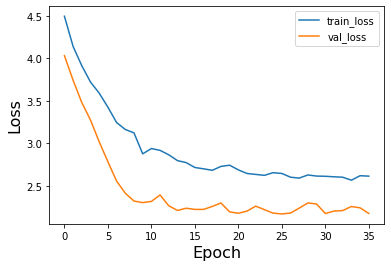

In [208]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

In [209]:
# predict for the cox model
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data

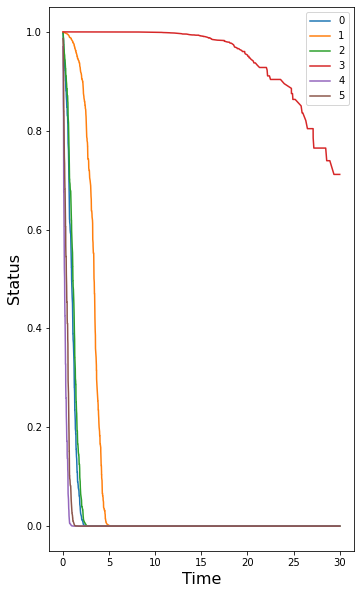

In [210]:
# plotting for few outputs
plt.figure(figsize=[12,10])
plt.subplot(121)
plt.plot(surv_cox.iloc[:, :6])
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Status' , fontsize = 16)
plt.legend(range(len(surv_cox.iloc[:, :20])))

In [211]:
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, duration_test, event_test)
cox_index = eval_cox.concordance_td() 
cox_index

0.99265605875153